In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# KMP_DUPLICATE_LIB_OK to avoid errors due to multiple libraries loading
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Set the logging level to suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

In [2]:
class Config:
    OUTPUT_CLASS_COUNT = 3  # Number of target classes
    AUGMENTATIONS = 5  # Number of augmentations per image
    BATCH_SIZE = 32  # Number of images per batch

In [3]:
# Function to preprocess one image for TensorFlow
def preprocess_tensorflow(image: np.ndarray, label=0) -> tuple:
    image = tf.convert_to_tensor(image)
    image_float32 = tf.cast(image, tf.float32)
    image_float32 = tf.math.divide(image_float32, 255.0)
    return image_float32, label
    
    
# Function to show 9 random images from the dataset
def show_random_images(dataset, class_names: list) -> None:
    plt.figure(figsize=(10, 10))
    for images, labels in dataset:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()


# Function to count total number of images in the dataset
def count_dataset(dataset) -> int:
    count = 0
    for images, _ in dataset:
        count += len(images)
    return count


# Function to show information like shape, dtype, mean of images in the dataset
def show_dataset_info(dataset) -> None:
    print(type(dataset))
    
    if hasattr(dataset, 'class_names'):
        print("Class names:", dataset.class_names)
    
    dataset_count = count_dataset(dataset)
    print("Total number of images in the dataset:", dataset_count)
    
    for a, b in dataset:
        print("Images shape:", a.shape)
        print("Labels shape:", b.shape)
        print("Original images dtype:", a.dtype)
        print("Labels dtype:", b.dtype)
        print("Original images mean:", tf.reduce_mean(a))
        break

In [4]:
print("Loading training data...")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train", image_size=(128, 128), batch_size=Config.BATCH_SIZE, labels="inferred", label_mode="int",
)
class_names = train_data.class_names # type: ignore

preprocessed_train_data = train_data.map(lambda x, y: (preprocess_tensorflow(x, y))) # type: ignore
preprocessed_train_data.class_names = train_data.class_names # type: ignore
print("")

print("Loading validation data...")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/val", image_size=(128, 128), batch_size=Config.BATCH_SIZE, labels="inferred", label_mode="int",
)
print("")


show_dataset_info(preprocessed_train_data)

Loading training data...
Found 15 files belonging to 3 classes.

Loading validation data...
Found 3 files belonging to 3 classes.

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
Class names: ['audi', 'bmw', 'volvo']
Total number of images in the dataset: 15
Images shape: (15, 128, 128, 3)
Labels shape: (15,)
Original images dtype: <dtype: 'float32'>
Labels dtype: <dtype: 'int32'>
Original images mean: tf.Tensor(0.40158343, shape=(), dtype=float32)


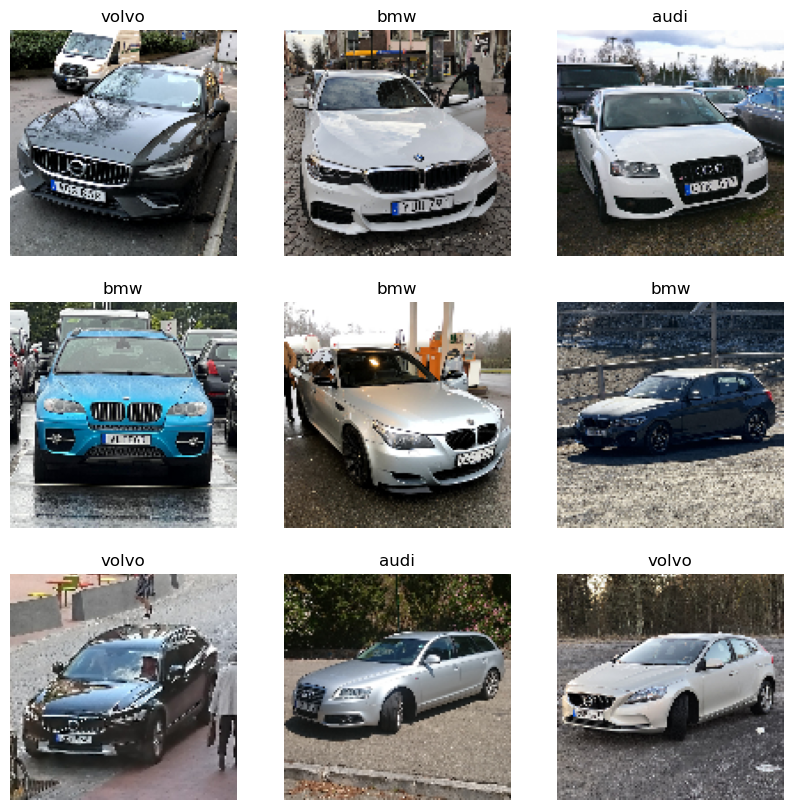

In [5]:
show_random_images(preprocessed_train_data, class_names) # type: ignore

In [6]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.5),
        tf.keras.layers.RandomZoom(0.5),
    ]
)

def generate_augmented_dataset(dataset: tf.data.Dataset) -> tf.data.Dataset:
    augmented_images = []
    labels_list = []

    for i in range(Config.AUGMENTATIONS):
        for images, labels in dataset:
            augmented_batch = data_augmentation(images)
            augmented_images.append(augmented_batch)
            labels_list.append(labels)

    augmented_images = tf.concat(augmented_images, axis=0)
    labels_list = tf.concat(labels_list, axis=0)
    
    # Return as dataset
    augmented_images = tf.data.Dataset.from_tensor_slices(augmented_images)
    labels_list = tf.data.Dataset.from_tensor_slices(labels_list)
    
    dataset = tf.data.Dataset.zip((augmented_images, labels_list))
    
    dataset.class_names = class_names # type: ignore
    
    return dataset

augmented_dataset = generate_augmented_dataset(preprocessed_train_data) # type: ignore

combined_dataset = preprocessed_train_data.concatenate(augmented_dataset)


In [7]:
show_dataset_info(augmented_dataset)
print("")
show_dataset_info(combined_dataset)

<class 'tensorflow.python.data.ops.dataset_ops.ZipDataset'>
Class names: ['audi', 'bmw', 'volvo']
Total number of images in the dataset: 9600
Images shape: (128, 128, 3)
Labels shape: ()
Original images dtype: <dtype: 'float32'>
Labels dtype: <dtype: 'int32'>
Original images mean: tf.Tensor(0.47452012, shape=(), dtype=float32)

<class 'tensorflow.python.data.ops.dataset_ops.ConcatenateDataset'>
Total number of images in the dataset: 9615
Images shape: (15, 128, 128, 3)
Labels shape: (15,)
Original images dtype: <dtype: 'float32'>
Labels dtype: <dtype: 'int32'>
Original images mean: tf.Tensor(0.40158343, shape=(), dtype=float32)


In [ ]:
show_random_images(combined_dataset, class_names) # type: ignore
show_random_images(combined_dataset, class_names) # type: ignore
show_random_images(combined_dataset, class_names) # type: ignore
show_random_images(combined_dataset, class_names) # type: ignore